# Tutorial on using the classes for transpiling DBQA strategies into various types of double-bracket rotations (DBRs)

## 1. VQE results are loaded
## 2. The GC3 DBR is shown using  the `GroupCommutatorIterationWithEvolutionOracles` class
### 3.1. It is shown how to perform more steps of the GCI. 
Using the class approach one can just change `mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_third_order_reduced` to a different type and same code will run.

In [1]:
import json
import time
from pathlib import Path

import numpy as np
import qibo
from qibo import hamiltonians, set_backend
from boostvqe.models.dbi.double_bracket import (
    DoubleBracketGeneratorType,
    DoubleBracketIteration,
)

from boostvqe.ansatze import VQE, build_circuit
from boostvqe.utils import apply_dbi_steps, rotate_h_with_vqe
from qibo import symbols, hamiltonians
from copy import deepcopy
from boostvqe.compiling_XXZ import *

import matplotlib.pyplot as plt

## 1. Loading VQE results

In [2]:

qibo.set_backend("numpy")

# set the path string which define the results
path = "../results/vqe_data/with_params/10q7l/sgd_10q_7l_42/"

# set the target epoch to which apply DBQA and the number of steps
target_epoch = 2000
dbi_steps = 1

# upload system configuration and parameters for all the training
with open(path + "optimization_results.json") as file:
    config = json.load(file)

losses = dict(np.load(path + "energies.npz"))["0"]
params = np.load(path + f"parameters/params_ite{target_epoch}.npy")

nqubits = config["nqubits"]
# build circuit, hamiltonian and VQE
hamiltonian = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)
circuit = build_circuit(nqubits, config["nlayers"], "numpy")
vqe = VQE(circuit, hamiltonian)
zero_state = hamiltonian.backend.zero_state(nqubits)
zero_state_t = np.transpose([zero_state])
target_energy = np.min(hamiltonian.eigenvalues())


# set target parameters into the VQE
vqe.circuit.set_parameters(params)
vqe_state = vqe.circuit().state()

ene1 = hamiltonian.expectation(vqe_state)


[Qibo 0.2.9|INFO|2024-06-13 15:49:17]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0
[Qibo 0.2.9|INFO|2024-06-13 15:49:17]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


In the VQE numpy


In [3]:
print(f"VQE energy is {ene1}. \n\
The target energy is {target_energy} which means the difference is {ene1-target_energy}.\n\
The relative difference is {abs(ene1-target_energy)/abs(target_energy)}%.")

VQE energy is -14.856898957126564. 
The target energy is -15.276131122065795 which means the difference is 0.4192321649392312.
The relative difference is 0.02744360869838739%.


# 2. 3 GCI3 steps for fixed
$D= \sum_i B_i Z_i$
and Group commutator

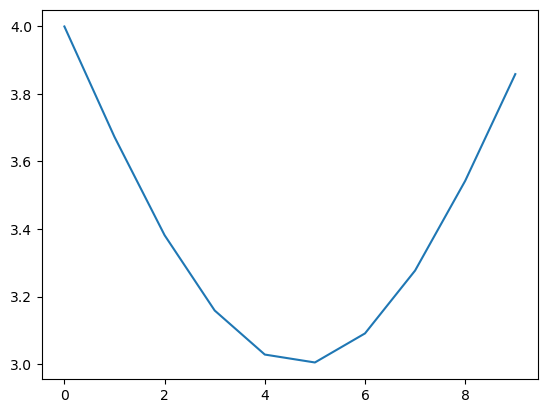

In [4]:
b_list = [4-np.sin(i/3) for i,x in enumerate(np.random.rand(10)) ]
                                  
plt.plot(b_list)

In [5]:
from boostvqe.models.dbi.group_commutator_iteration_transpiler import *
from boostvqe.models.dbi.double_bracket_evolution_oracles import *

eo_xxz = XXZ_EvolutionOracle(nqubits, steps = 3, order = 2)

# implement the rotate by VQE on the level of circuits
fsoe  = VQERotatedEvolutionOracle(eo_xxz, vqe)

# init gci with the vqe-rotated hamiltonian
gci  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_reduced)

gci.print_gate_count_report()

In [1]:
# init the generator of the evolution,
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
eo_d = MagneticFieldEvolutionOracle(b_list,name = "D(linear)")
times = np.linspace( 0.001,0.003,30)
step,loss, losses = gci.choose_step(d = eo_d,times = times)
print(loss)

plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])
print(min(losses))
s_gc3 = times[np.argmin(losses)]

NameError: name 'MagneticFieldEvolutionOracle' is not defined

In [9]:
step

0.0024545454545454545

In [29]:
gci.loss(step, eo_d)

-14.801884982344752

In [11]:
gci(step, eo_d)
gci.print_gate_count_report()

The boosting circuit used 135 CNOT gates coming from compiled XXZ evolution and 210 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 13.5 and n_CZ/n_qubits = 21.0


In [30]:
gci.h_ref.expectation(gci.get_composed_circuit()().state())

-14.935556941199138

In [34]:
v1_circ = gci.get_composed_circuit()
fsoe2  = FrameShiftedEvolutionOracle(deepcopy(eo_xxz),before_circuit=v1_circ.invert(), after_circuit=v1_circ, name="fixing bug")
# init gci with the vqe-rotated hamiltonian
gci2  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe2, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_reduced)

In [33]:
gci2.loss()

-14.935556941199138

In [25]:
gci2.loss(0.0000000002,eo_d)

-14.856934920331803

In [26]:
losses = []
eo_d2 = MagneticFieldEvolutionOracle(b_list)
for s in np.linspace(4e-3,1e-2,30):
    losses.append(gci2.loss(s,eo_d2))
plt.plot(losses)

KeyboardInterrupt: 

In [ ]:
gci(step, eo_d)
gci.print_gate_count_report()

The boosting circuit used 945 CNOT gates coming from compiled XXZ evolution and 1050 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 94.5 and n_CZ/n_qubits = 105.0


In [ ]:
losses = []
eo_d2 = MagneticFieldEvolutionOracle(np.random.rand(10))
gci_circuit = gci.get_composed_circuit()
hamiltonian.expectation( (gci_circuit)().state())


-14.712766808025183

In [ ]:
for s in np.linspace(1e-7,3e-3,30):
    circuit = gci.group_commutator(s, eo_d2, mode_dbr=DoubleBracketRotationType.group_commutator_third_order_reduced)["forwards"]
    c =circuit + gci_circuit
    losses.append(hamiltonian.expectation( (c)().state()))
plt.plot(losses)

KeyboardInterrupt: 

In [ ]:
gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
step,loss = gci.choose_step(d = eo_d,max_evals=34,step_min = 0.0002,step_max = 0.007)
loss

KeyboardInterrupt: 

In [ ]:
step

0.0002

In [ ]:
gci(step, eo_d)
gci.print_gate_count_report()

The boosting circuit used 540 CNOT gates coming from compiled XXZ evolution and 630 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 54.0 and n_CZ/n_qubits = 63.0


In [ ]:
step,loss = gci.choose_step(d = eo_d,max_evals=34,step_min = 0.002,step_max = 0.007)
loss

KeyboardInterrupt: 

In [ ]:
gci(step, eo_d)
gci.print_gate_count_report()

The boosting circuit used 1755 CNOT gates coming from compiled XXZ evolution and 1890 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 175.5 and n_CZ/n_qubits = 189.0


In [ ]:
def gradient_numerical(
    dbi_object: DoubleBracketIteration,
    d_params: list,
    parameterization: ParameterizationTypes,
    s: float = 1e-2,
    delta: float = 1e-3,
    backend=None,
    loss_0 = None,
    **kwargs,
):
    r"""
    Gradient of the DBI with respect to the parametrization of D. A simple finite difference is used to calculate the gradient.

    Args:
        dbi_object (DoubleBracketIteration): DoubleBracketIteration object.
        d_params (np.array): Parameters for the ansatz (note that the dimension must be 2**nqubits for full ansazt and nqubits for Pauli ansatz).
        s (float): A short flow duration for finding the numerical gradient.
        delta (float): Step size for numerical gradient.
    Returns:
        grad (np.array): Gradient of the D operator.
    """

    nqubits = dbi_object.nqubits
    grad = np.zeros(len(d_params))
    d = params_to_diagonal_operator(
        d_params, nqubits, parameterization=parameterization, **kwargs
    )
    if loss_0 is None:
        loss_0 = dbi_object.loss(s, d)
    for i in range(len(d_params)):
        params_new = deepcopy(d_params)
        params_new[i] += delta
        d_new = params_to_diagonal_operator(
            params_new, nqubits, parameterization=parameterization, **kwargs
        )
        # find the increment of a very small step
        grad[i] = (dbi_object.loss(s, d_new) - loss_0 ) / delta
    return grad

In [ ]:
d_new = params_to_diagonal_operator(
            b_list, nqubits, parameterization=ParameterizationTypes.circuits
        )

In [ ]:
dd = d + SymbolicHamiltonian(symbols.Z(0)*0.001,nqubits=10)

NameError: name 'd' is not defined

In [ ]:
def params_to_diagonal_operator_ising(
            d_params_test,
            nqubits
        ):
    b_list = d_params_test[:nqubits]
    j_couplings = d_params_test[nqubits:]
    d = hamiltonians.SymbolicHamiltonian( sum([b*symbols.Z(j)*symbols.Z(0) for j,b in zip(range(nqubits),b_list)]\
                                               + [j*zz for j,zz in zip(j_couplings,zz_terms)]))
    return EvolutionOracle(d,mode_evolution_oracle=EvolutionOracleType.hamiltonian_simulation,name = "D(linear)")



In [ ]:
def gradient_descent_circuits(
    dbi_object: DoubleBracketIteration,
    train_epochs: int,
    d_params_init: list,
    lr: float = 1e-2,
    step_guess = 0.01
):

    nqubits = dbi_object.nqubits

    d_params_store = []
    s_store = []
    loss_store = []


    d_init = params_to_diagonal_operator(
                d_params_init,
                nqubits,
                parameterization=ParameterizationTypes.circuits
            )
    step_guess,loss = dbi_object.choose_step(d = eo_d,step_min=0.001,step_max=0.01, max_evals=45)
    print(loss)
    d_params_test = d_params_init
    for i in range(train_epochs):
        print(i)
        # find gradient
        grad = gradient_numerical_circuits(
            dbi_object,
            d_params_test,
            ParameterizationTypes.circuits,
            s=step_guess,
            loss_0 = loss
        )
        d_params_test = [d_params_init[j] - grad[j] * lr for j in range(len(grad))]
        d = params_to_diagonal_operator(
            d_params_test,
            nqubits,
            parameterization=ParameterizationTypes.circuits
        )
        step_guess, loss = dbi_object.choose_step(d=d,step_min=3e-3,step_max=0.008, max_evals=35,verbose=False)
        print(loss)
        d_params_store.append(d_params_test)
        s_store.append(step_guess)
        loss_store.append(loss)

    min_loss = min(loss_store)
    idx_min = loss_store.index(min_loss)
    d_params_test = d_params_store[idx_min]
    s = s_store[idx_min]

    return d_params_test, s, min_loss

In [ ]:
d_params_test, s, min_loss = gradient_descent_circuits(
gci,
 train_epochs=9,
   d_params_init=b_list,
   lr=.01
)

KeyboardInterrupt: 

In [ ]:
s,loss = gci.choose_step(d = params_to_diagonal_operator(
            d_params_test,
            nqubits,
            parameterization=ParameterizationTypes.circuits
        ),step_max=0.007,step_min=0.003, max_evals=64)

In [ ]:
gci(s, params_to_diagonal_operator(
            d_params_test,
            nqubits,
            parameterization=ParameterizationTypes.circuits
        ))


In [ ]:
loss

-14.984262401527271

In [ ]:
step,loss = gci.choose_step(d = eo_d,step_max=0.007,step_min=0.003, max_evals=64)

In [ ]:
step

0.0061111111111111106

In [ ]:
loss

-15.03199796593811

In [ ]:
d_params_test2, s, min_loss = gradient_descent_circuits(
gci,
 train_epochs=2,
   d_params_init=np.random.rand(10),
   lr=.01
)

-15.0319979962218
0
-14.989159605755157
1
-15.00315996093362


In [ ]:
d_params_test3, s, min_loss = gradient_descent_circuits(
gci,
 train_epochs=6,
   d_params_init=d_params_test2,
   lr=.01
)

-15.0319979962218
0
-14.98916290692736
1
-15.003161832059906
2
-15.003161354487506
3
-15.003161354507414
4
-15.003161354507405
5
-15.003161354507506


In [ ]:
np.max(np.array(d_params_test) - np.array(b_list))

-9.46347320507357e-06

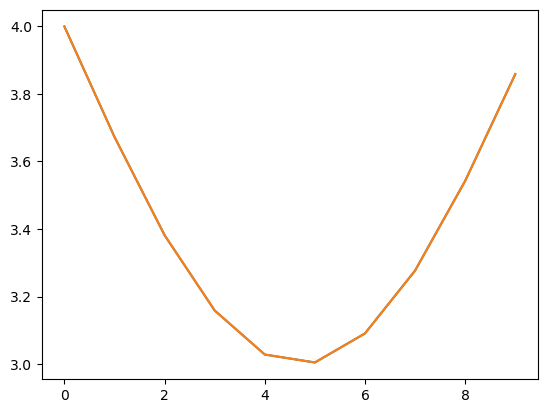

In [ ]:
plt.plot(d_params_test)
plt.plot(b_list)

In [ ]:
step,loss = gci.choose_step(d = eo_d,step_min=0.0001,step_max=1.15*0.01, max_evals=25)

In [ ]:
loss

-15.031976326074851

In [ ]:
step

0.006275

In [ ]:
step,loss = gci.choose_step(d = params_to_diagonal_operator(
            d_params_test,
            nqubits,
            parameterization=ParameterizationTypes.circuits
        ),step_min=0.003,step_max=1.15*0.01, max_evals=85)

In [ ]:
loss

-15.031997828897188

In [ ]:
step

0.006136904761904762

In [ ]:
m = params_to_diagonal_operator(
            d_params_test,
            nqubits,
            parameterization=ParameterizationTypes.circuits
        ).h.dense.matrix

[Qibo 0.2.9|WARNING|2024-06-13 00:03:38]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


In [ ]:
D = np.diag(m)

In [ ]:
hvqe_matrix = rotate_h_with_vqe(hamiltonian=hamiltonian, vqe=vqe)

In [ ]:
Dvqe = np.diag(hvqe_matrix)

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


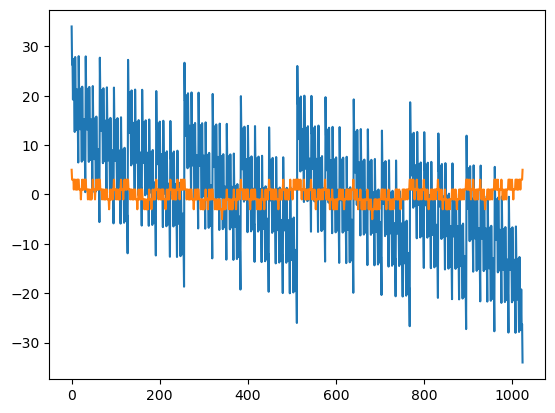

In [ ]:
plt.plot(D)
plt.plot(Dvqe)

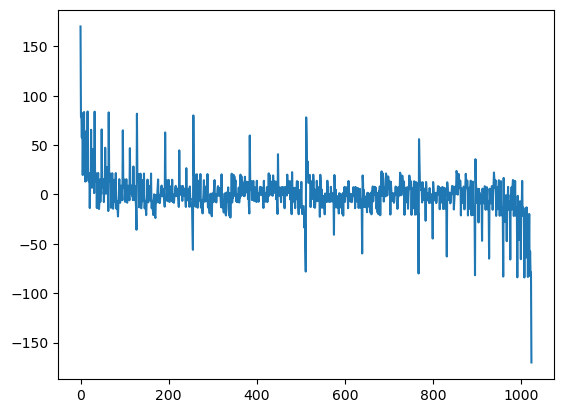

In [ ]:
plt.plot([x*y for x,y in zip(Dvqe,D)])

In [ ]:
np.sum([x*y for x,y in zip(Dvqe,D)])

0j

In [ ]:

hvqe_matrix.shape


(1024, 1024)

In [ ]:
SymbolicHamiltonian(symbols.Z(0),nqubits=nqubits).dense.matrix.shape

[Qibo 0.2.9|WARNING|2024-06-13 00:04:10]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


(1024, 1024)

In [ ]:
for i in range(nqubits):
    print(np.trace(hvqe_matrix@(SymbolicHamiltonian(symbols.Z(i)*symbols.Z(0),nqubits=nqubits).dense.matrix)))

[Qibo 0.2.9|WARNING|2024-06-13 00:04:10]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.9|WARNING|2024-06-13 00:04:15]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j


[Qibo 0.2.9|WARNING|2024-06-13 00:04:21]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


(512+0j)


[Qibo 0.2.9|WARNING|2024-06-13 00:04:26]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j


[Qibo 0.2.9|WARNING|2024-06-13 00:04:31]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j


[Qibo 0.2.9|WARNING|2024-06-13 00:04:36]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j


[Qibo 0.2.9|WARNING|2024-06-13 00:04:42]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j


[Qibo 0.2.9|WARNING|2024-06-13 00:04:47]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j


[Qibo 0.2.9|WARNING|2024-06-13 00:04:52]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j


[Qibo 0.2.9|WARNING|2024-06-13 00:04:57]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0j
(512+0j)
